CHURN PREDICTION MODEL

Setting up

1.LOADING DATA

 Data loaded successfully!
  Shape: 146194 rows × 10 columns
  Date range: 2025-07-03 00:00:00 to 2025-09-01 00:00:00
  Unique users: 9340

Column names:
['user_id', 'date', 'session_duration', 'screens_viewed', 'app_opens', 'device_type', 'user_acquisition_channel', 'user_segment', 'daily_active_users', 'retention_rate']

First 5 rows:
         user_id       date  session_duration  screens_viewed  app_opens  \
0  user_00133a5c 2025-07-03            158.55              85          1   
1  user_00133a5c 2025-07-05            150.03              78          1   
2  user_00133a5c 2025-07-06            130.16              68          1   
3  user_00133a5c 2025-07-07            154.37              82          1   
4  user_00133a5c 2025-07-09            113.88              58          1   

  device_type user_acquisition_channel user_segment  daily_active_users  \
0         iOS                   direct  power_users                2189   
1         iOS                   direct

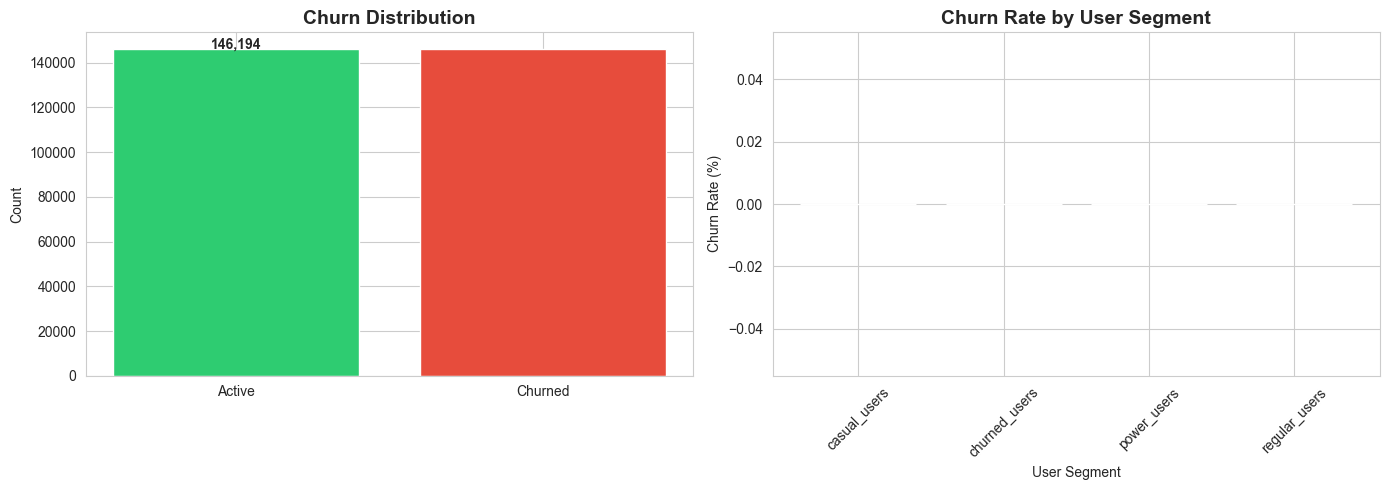


Churn rate by user segment:
user_segment
casual_users     0.0
churned_users    0.0
power_users      0.0
regular_users    0.0
Name: churned, dtype: float64


In [1]:
# MOBILE APP CHURN PREDICTION MODEL -

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

#1.LOAD AND EXPLORE DATA

print("=" * 70)
print("1.LOADING DATA")
print("=" * 70)

df = pd.read_csv(r"C:\Users\sjn17\Downloads\mobile_app_analytics\data\mobile_analytics.csv")
df['date'] = pd.to_datetime(df['date'])

print(f"\n Data loaded successfully!")
print(f"  Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
print(f"  Unique users: {df['user_id'].nunique()}")

print(f"\nColumn names:")
print(df.columns.tolist())

print(f"\nFirst 5 rows:")
print(df.head())

print(f"\nData types:")
print(df.dtypes)

print(f"\nMissing values:")
print(df.isnull().sum())

print(f"\nBasic statistics:")
print(df.describe())

#2.CREATE CHURN LABEL

print("\n" + "=" * 70)
print("2.DEFINING CHURN")
print("=" * 70)

# Define churn: retention_rate < 0.3 (30%)
df['churned'] = (df['retention_rate'] < 0.3).astype(int)
df

print(f"\nChurn threshold: retention_rate < 30%")
print(f"\nChurn distribution:")
print(f"  Active (0): {(df['churned']==0).sum():,} ({(1-df['churned'].mean())*100:.2f}%)")
print(f"  Churned (1): {df['churned'].sum():,} ({df['churned'].mean()*100:.2f}%)")

# Visualize churn distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
churn_counts = df['churned'].value_counts()
axes[0].bar(['Active', 'Churned'], churn_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Churn Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')

# Churn by segment
segment_churn = df.groupby('user_segment')['churned'].mean().sort_values(ascending=False)
axes[1].bar(segment_churn.index, segment_churn.values * 100, color='coral')
axes[1].set_title('Churn Rate by User Segment', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].set_xlabel('User Segment')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nChurn rate by user segment:")
print(segment_churn * 100)

feature engineering

In [2]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv(r"C:\Users\sjn17\Downloads\mobile_app_analytics\data\mobile_analytics.csv")
df['date'] = pd.to_datetime(df['date'])
#2.CREATE CHURN LABEL

print("\n" + "=" * 70)
print("2.DEFINING CHURN")
print("=" * 70)

# Define churn: retention_rate < 0.3 (30%)
df['churned'] = (df['retention_rate'] < 0.3).astype(int)

print(f"Data loaded: {df.shape}")
print(f"Users: {df['user_id'].nunique()}")
print(df.head())


2.DEFINING CHURN
Data loaded: (146194, 11)
Users: 9340
         user_id       date  session_duration  screens_viewed  app_opens  \
0  user_00133a5c 2025-07-03            158.55              85          1   
1  user_00133a5c 2025-07-05            150.03              78          1   
2  user_00133a5c 2025-07-06            130.16              68          1   
3  user_00133a5c 2025-07-07            154.37              82          1   
4  user_00133a5c 2025-07-09            113.88              58          1   

  device_type user_acquisition_channel user_segment  daily_active_users  \
0         iOS                   direct  power_users                2189   
1         iOS                   direct  power_users                2834   
2         iOS                   direct  power_users                2861   
3         iOS                   direct  power_users                2202   
4         iOS                   direct  power_users                2214   

   retention_rate  churned  
0      

In [3]:
#3.FEATURE ENGINEERING

print("\n" + "=" * 70)
print("STEP 3: FEATURE ENGINEERING")
print("=" * 70)

# Aggregate features at user level
user_features = df.groupby('user_id').agg({
    # Behavioral metrics
    'session_duration': ['mean', 'std', 'min', 'max', 'sum'],
    'screens_viewed': ['mean', 'sum', 'max', 'std'],
    'app_opens': ['mean', 'sum', 'max', 'std'],
    
    # Engagement metrics
    'retention_rate': ['mean', 'min', 'max', 'std'],
    'daily_active_users': ['mean', 'std'],
    
    # Target variable
    'churned': 'max',

    # Activity frequency
    'date': 'count'  
}).reset_index()

# Flatten column names
user_features.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                          for col in user_features.columns.values]

# Rename for clarity
user_features.rename(columns={
    'date_count': 'total_active_days',
    'churned_max': 'churned'
}, inplace=True)

# Handle NaN values (from std calculations with single observations)
user_features = user_features.fillna(0)

print(f"\n User-level features created!")
print(f"  Total users: {len(user_features):,}")
print(f"  Total features: {len(user_features.columns)}")

# Add categorical features
categorical_features = df.groupby('user_id')[
    ['device_type', 'user_acquisition_channel', 'user_segment']
].first().reset_index()

user_features = user_features.merge(categorical_features, on='user_id', how='left')

print(f"\n Categorical features added!")
print(f"  Device types: {user_features['device_type'].nunique()}")
print(f"  Acquisition channels: {user_features['user_acquisition_channel'].nunique()}")
print(f"  User segments: {user_features['user_segment'].nunique()}")

print(f"\nUser churn distribution:")
print(f"  Churned users: {user_features['churned'].sum():,} ({user_features['churned'].mean()*100:.2f}%)")
print(f"  Active users: {(user_features['churned']==0).sum():,} ({(1-user_features['churned'].mean())*100:.2f}%)")

print(f"\nSample of engineered features:")
print(user_features.head())

#4.ENCODE CATEGORICAL VARIABLES

print("\n" + "=" * 70)
print("4.ENCODING CATEGORICAL VARIABLES")
print("=" * 70)

print(f"\nBefore encoding: {user_features.shape[1]} columns")

# One-hot encode
user_features_encoded = pd.get_dummies(
    user_features,
    columns=['device_type', 'user_acquisition_channel', 'user_segment'],
    drop_first=True
)

print(f"After encoding: {user_features_encoded.shape[1]} columns")
print(f"\n Categorical variables encoded successfully!")

#5.TRAIN/TEST SPLIT

print("\n" + "=" * 70)
print("5.PREPARING TRAIN/TEST SPLIT")
print("=" * 70)

# Separate features and target
X = user_features_encoded.drop(['user_id', 'churned'], axis=1)
y = user_features_encoded['churned']

print(f"\nFeatures (X): {X.shape}")
print(f"Target (y): {y.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\n Data split successfully!")
print(f"  Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\n  Training churn rate: {y_train.mean()*100:.2f}%")
print(f"  Test churn rate: {y_test.mean()*100:.2f}%")


STEP 3: FEATURE ENGINEERING

 User-level features created!
  Total users: 9,340
  Total features: 22

 Categorical features added!
  Device types: 2
  Acquisition channels: 8
  User segments: 4

User churn distribution:
  Churned users: 0 (0.00%)
  Active users: 9,340 (100.00%)

Sample of engineered features:
         user_id  session_duration_mean  session_duration_std  \
0  user_00133a5c             130.448241             53.240855   
1  user_0019cc4c              34.378095             23.634315   
2  user_001b7b4d              40.456154             19.929979   
3  user_0022e396              34.350714             18.593422   
4  user_00243d23              39.838667             18.292182   

   session_duration_min  session_duration_max  session_duration_sum  \
0                 18.99                253.77           6000.619092   
1                  6.13                100.67            721.940000   
2                 10.88                 93.92           1051.860000   
3            

Training Random Forest model

In [ ]:
# 6. TRAIN RANDOM FOREST MODEL
print("\n" + "=" * 70)
print("6. TRAINING RANDOM FOREST MODEL")
print("=" * 70)

# First, verify we have both classes
print(f"\nClass distribution check:")
print(f"Training set - Churned: {y_train.sum()}, Active: {(y_train==0).sum()}")
print(f"Test set - Churned: {y_test.sum()}, Active: {(y_test==0).sum()}")

# Check if we have both classes
if len(y_train.unique()) < 2:
    print("\n ERROR: Only one class in training data!")
    print("Adjusting churn threshold...")
    
    # Use median retention_rate as threshold
    median_retention = df['retention_rate'].median()
    df['churned'] = (df['retention_rate'] < median_retention).astype(int)
    
    print(f"New churn threshold: {median_retention:.2f}")
    print(f"New churn rate: {df['churned'].mean()*100:.2f}%")
    
    # Rebuild features with new threshold
    user_features['churned'] = df.groupby('user_id')['churned'].max().values
    user_features_encoded = pd.get_dummies(
        user_features,
        columns=['device_type', 'user_acquisition_channel', 'user_segment'],
        drop_first=True
    )
    
    X = user_features_encoded.drop(['user_id', 'churned'], axis=1)
    y = user_features_encoded['churned']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f" Data rebuilt with both classes!")

print("\nInitializing Random Forest Classifier...")
print("  - n_estimators: 100")
print("  - max_depth: 10")
print("  - min_samples_split: 20")
print("  - class_weight: balanced")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

print("\nTraining model... (this may take 30-60 seconds)")
rf_model.fit(X_train, y_train)
print("✓ Model trained successfully!")

# Make predictions with safety check
print("\nMaking predictions...")
y_pred = rf_model.predict(X_test)

# Safe probability extraction
proba_matrix = rf_model.predict_proba(X_test)
if proba_matrix.shape[1] == 1:
    # Only one class predicted
    y_pred_proba = proba_matrix[:, 0]
    print(" Note: Model only learned one class. Results may be limited.")
else:
    # Both classes present
    y_pred_proba = proba_matrix[:, 1]

print("✓ Predictions completed!")
print(f"  Predicted churned: {y_pred.sum()}")
print(f"  Predicted active: {(y_pred==0).sum()}")


6. TRAINING RANDOM FOREST MODEL

Class distribution check:
Training set - Churned: 0, Active: 7472
Test set - Churned: 0, Active: 1868

 ERROR: Only one class in training data!
Adjusting churn threshold...
New churn threshold: 23.38
New churn rate: 48.13%
 Data rebuilt with both classes!

Initializing Random Forest Classifier...
  - n_estimators: 100
  - max_depth: 10
  - min_samples_split: 20
  - class_weight: balanced

Training model... (this may take 30-60 seconds)
✓ Model trained successfully!

Making predictions...
✓ Predictions completed!
  Predicted churned: 1764
  Predicted active: 104


Model evaluation metrics


7.MODEL EVALUATION METRICS

Accuracy: 1.0000 (100.00%)

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

      Active       1.00      1.00      1.00       104
     Churned       1.00      1.00      1.00      1764

    accuracy                           1.00      1868
   macro avg       1.00      1.00      1.00      1868
weighted avg       1.00      1.00      1.00      1868


=== CONFUSION MATRIX ===
True Negatives (Active predicted as Active): 104
False Positives (Active predicted as Churned): 0
False Negatives (Churned predicted as Active): 0
True Positives (Churned predicted as Churned): 1764

=== ROC-AUC SCORE ===
ROC-AUC: 1.0000

8.CREATING VISUALIZATIONS


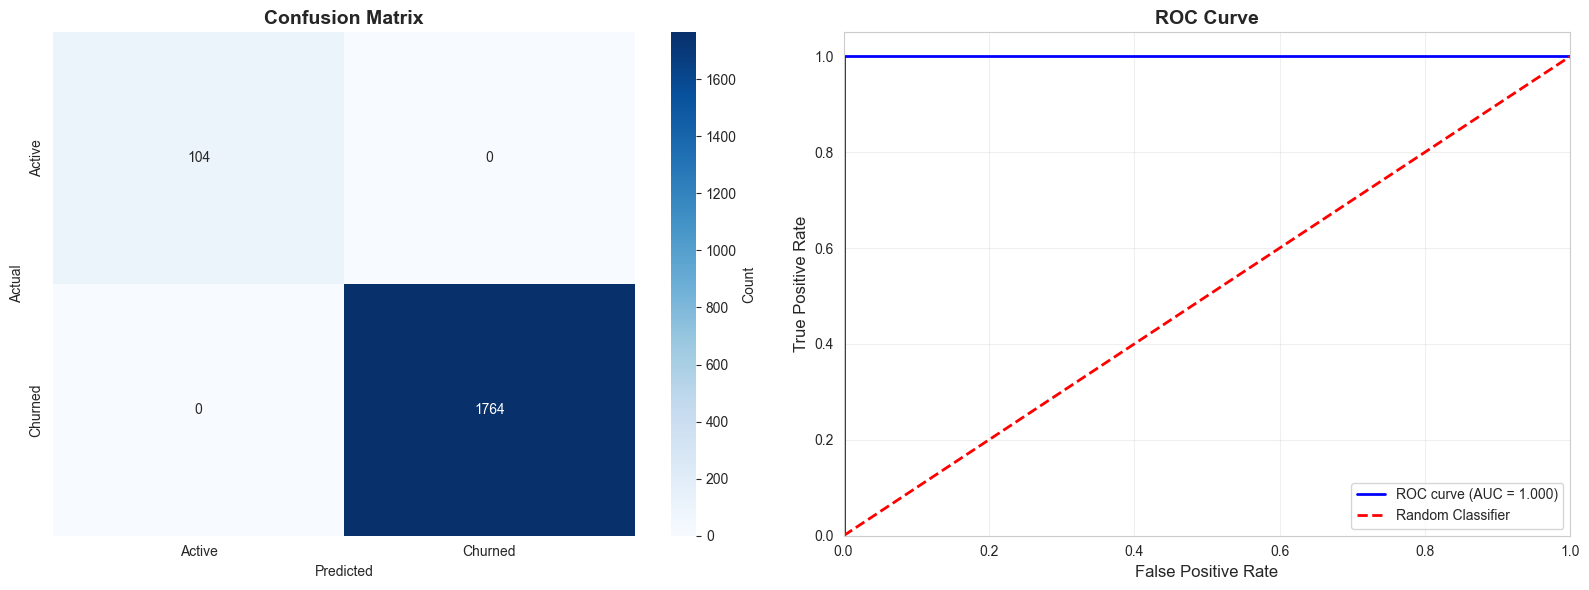


=== TOP 15 FEATURE IMPORTANCES ===
                feature  importance
     retention_rate_min    0.338853
          app_opens_sum    0.111600
      total_active_days    0.083350
   session_duration_sum    0.073525
     screens_viewed_sum    0.073204
    retention_rate_mean    0.063232
   session_duration_std    0.048025
     screens_viewed_std    0.039817
daily_active_users_mean    0.039066
     retention_rate_std    0.029381
   session_duration_max    0.020200
 daily_active_users_std    0.019319
  session_duration_mean    0.019001
     retention_rate_max    0.014567
    screens_viewed_mean    0.011604


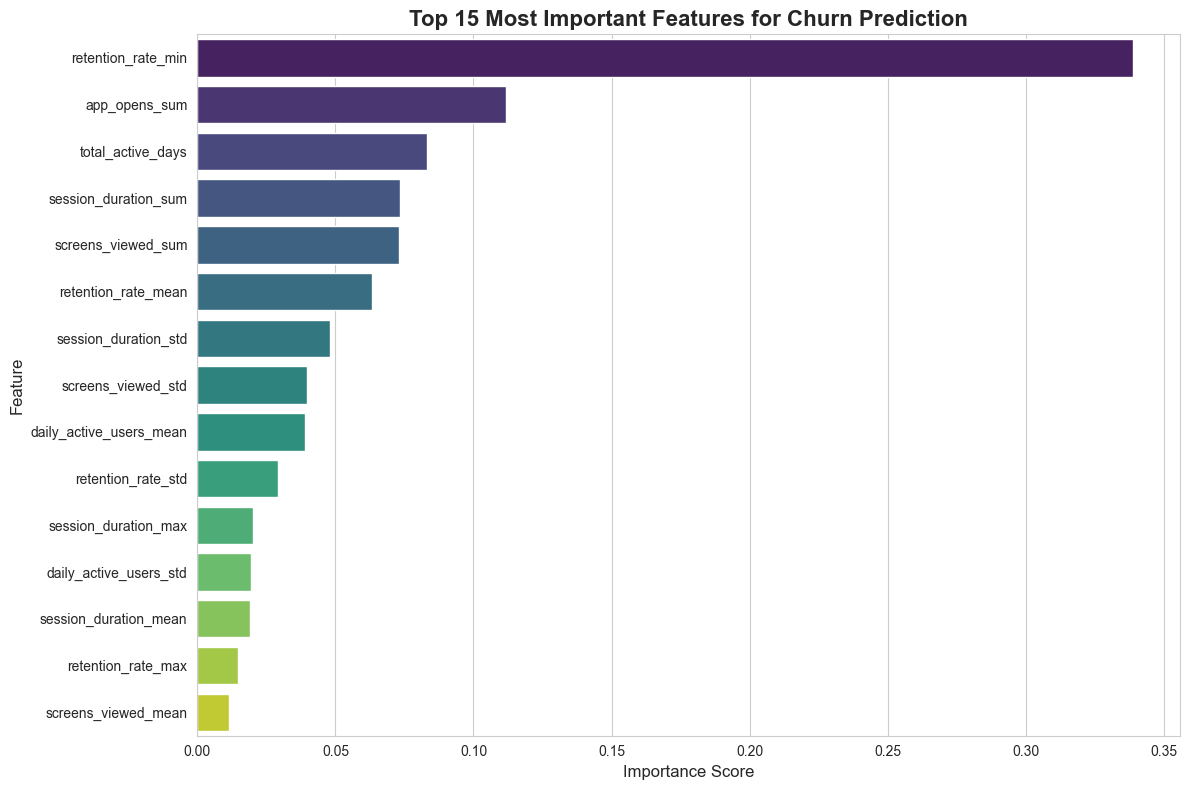

In [5]:
#7.MODEL EVALUATION

print("\n" + "=" * 70)
print("7.MODEL EVALUATION METRICS")
print("=" * 70)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification Report
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=['Active', 'Churned']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n=== CONFUSION MATRIX ===")
print(f"True Negatives (Active predicted as Active): {cm[0,0]}")
print(f"False Positives (Active predicted as Churned): {cm[0,1]}")
print(f"False Negatives (Churned predicted as Active): {cm[1,0]}")
print(f"True Positives (Churned predicted as Churned): {cm[1,1]}")

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\n=== ROC-AUC SCORE ===")
print(f"ROC-AUC: {roc_auc:.4f}")

#8.VISUALIZATIONS

print("\n" + "=" * 70)
print("8.CREATING VISUALIZATIONS")
print("=" * 70)

# Confusion Matrix Heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Active', 'Churned'],
            yticklabels=['Active', 'Churned'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Feature Importance
print("\n=== TOP 15 FEATURE IMPORTANCES ===")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(15).to_string(index=False))

# Plot Feature Importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Top 15 Most Important Features for Churn Prediction', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

BUSINESS INSIGHTS

Root cause analysis of DAU decline


9.ROOT CAUSE ANALYSIS OF DAU DECLINE


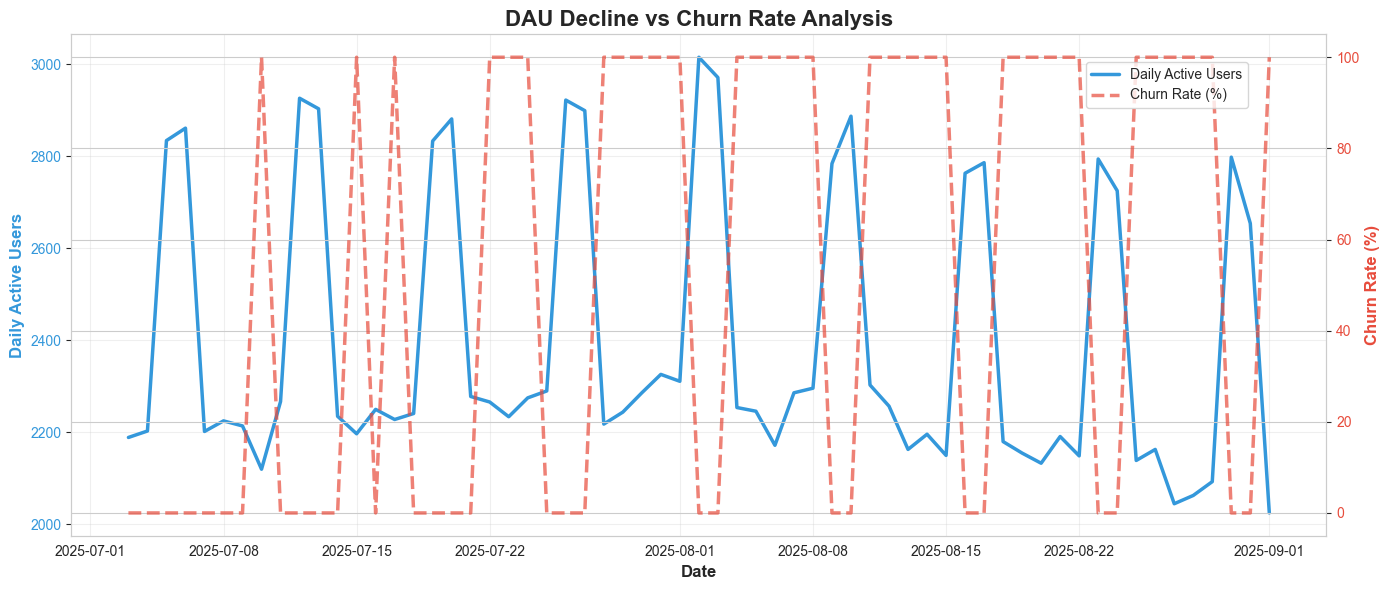


- Correlation between DAU and Churn Rate: -0.6904
   → Strong negative correlation: As DAU declines, churn increases significantly


In [6]:
#9.BUSINESS INSIGHTS - ROOT CAUSE ANALYSIS

print("\n" + "=" * 70)
print("9.ROOT CAUSE ANALYSIS OF DAU DECLINE")
print("=" * 70)

# Analyze DAU trend over time
daily_metrics = df.groupby('date').agg({
    'daily_active_users': 'first',
    'churned': 'mean',
    'session_duration': 'mean',
    'retention_rate': 'mean',
    'app_opens': 'sum'
}).reset_index()

# Plot DAU trend with churn overlay
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(daily_metrics['date'], daily_metrics['daily_active_users'], 
         color='#3498db', linewidth=2.5, label='Daily Active Users')
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Daily Active Users', color='#3498db', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#3498db')
ax1.grid(alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(daily_metrics['date'], daily_metrics['churned']*100, 
         color='#e74c3c', linewidth=2.5, linestyle='--', label='Churn Rate (%)', alpha=0.7)
ax2.set_ylabel('Churn Rate (%)', color='#e74c3c', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#e74c3c')

plt.title('DAU Decline vs Churn Rate Analysis', fontsize=16, fontweight='bold')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
fig.tight_layout()
plt.show()

# Calculate correlation
dau_churn_corr = daily_metrics['daily_active_users'].corr(daily_metrics['churned'])
print(f"\n- Correlation between DAU and Churn Rate: {dau_churn_corr:.4f}")

if dau_churn_corr < -0.5:
    print("   → Strong negative correlation: As DAU declines, churn increases significantly")
elif dau_churn_corr < -0.3:
    print("   → Moderate negative correlation: DAU decline is related to increased churn")
else:
    print("   → Weak correlation: Other factors may be driving DAU decline")

Identify high-risk user segments


10.IDENTIFYING HIGH-RISK USER SEGMENTS

=== RISK LEVEL DISTRIBUTION ===
  High Risk: 8,822 users (94.5%)
  Low Risk: 427 users (4.6%)
  Medium Risk: 3 users (0.0%)

= CHURN RISK BY USER SEGMENT ===
                   mean  count
user_segment                  
power_users    0.999992   1521
regular_users  0.999032   3469
casual_users   0.935507   3540
churned_users  0.594231    810

= CHURN RISK BY DEVICE TYPE ===
                 mean  count
device_type                 
iOS          0.943099   2613
Android      0.938804   6727

= CHURN RISK BY ACQUISITION CHANNEL ===
                              mean  count
user_acquisition_channel                 
direct                    0.954507    446
referral                  0.950840    745
email                     0.948947    478
app_store                 0.942643   1368
paid_search               0.939708   1052
paid_social               0.938682   1873
organic                   0.935481   3193
unknown                   0.911995    185


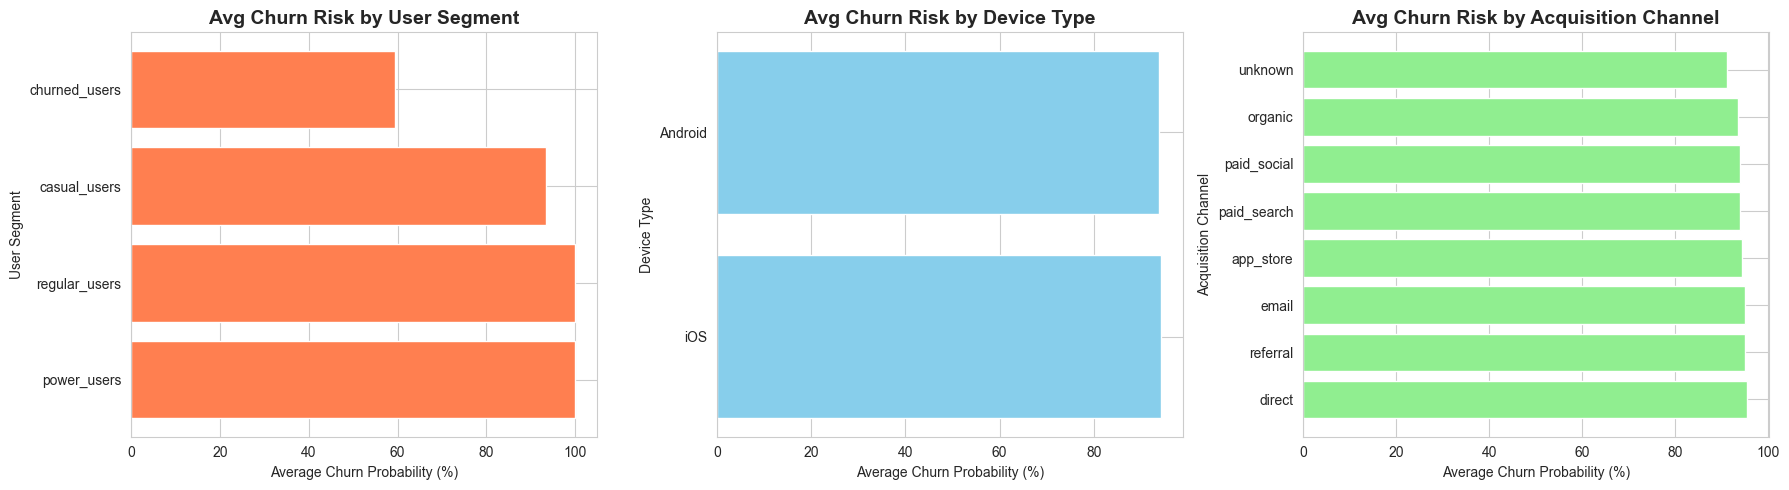

In [7]:
#10.IDENTIFY HIGH-RISK USER SEGMENTS

print("\n" + "=" * 70)
print("10.IDENTIFYING HIGH-RISK USER SEGMENTS")
print("=" * 70)

# Predict churn probability for all users
user_features_encoded['churn_probability'] = rf_model.predict_proba(X)[:, 1]

# Merge with original features for analysis
high_risk_analysis = user_features.merge(
    user_features_encoded[['user_id', 'churn_probability']], 
    on='user_id'
)

# Define risk levels
high_risk_analysis['risk_level'] = pd.cut(
    high_risk_analysis['churn_probability'],
    bins=[0, 0.3, 0.6, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

print(f"\n=== RISK LEVEL DISTRIBUTION ===")
risk_dist = high_risk_analysis['risk_level'].value_counts()
for level, count in risk_dist.items():
    print(f"  {level}: {count:,} users ({count/len(high_risk_analysis)*100:.1f}%)")

# Analyze by user segment
print(f"\n= CHURN RISK BY USER SEGMENT ===")
segment_risk = high_risk_analysis.groupby('user_segment')['churn_probability'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print(segment_risk)

# Analyze by device type
print(f"\n= CHURN RISK BY DEVICE TYPE ===")
device_risk = high_risk_analysis.groupby('device_type')['churn_probability'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print(device_risk)

# Analyze by acquisition channel
print(f"\n= CHURN RISK BY ACQUISITION CHANNEL ===")
channel_risk = high_risk_analysis.groupby('user_acquisition_channel')['churn_probability'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print(channel_risk)

# Visualize high-risk segments
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# By User Segment
segment_risk_plot = segment_risk.sort_values('mean', ascending=False)
axes[0].barh(segment_risk_plot.index, segment_risk_plot['mean']*100, color='coral')
axes[0].set_title('Avg Churn Risk by User Segment', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Average Churn Probability (%)')
axes[0].set_ylabel('User Segment')

# By Device Type
device_risk_plot = device_risk.sort_values('mean', ascending=False)
axes[1].barh(device_risk_plot.index, device_risk_plot['mean']*100, color='skyblue')
axes[1].set_title('Avg Churn Risk by Device Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Average Churn Probability (%)')
axes[1].set_ylabel('Device Type')

# By Acquisition Channel
channel_risk_plot = channel_risk.sort_values('mean', ascending=False)
axes[2].barh(channel_risk_plot.index, channel_risk_plot['mean']*100, color='lightgreen')
axes[2].set_title('Avg Churn Risk by Acquisition Channel', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Average Churn Probability (%)')
axes[2].set_ylabel('Acquisition Channel')

plt.tight_layout()
plt.show()

Deliverable: ML model + business insights

In [8]:
#11.BUSINESS INSIGHTS SUMMARY
# ============================================================================
print("\n" + "=" * 70)
print("BUSINESS INSIGHTS SUMMARY")
print("=" * 70)

print(f"\n1. MODEL PERFORMANCE:")
print(f"   • ROC-AUC Score: {roc_auc:.3f}")
print(f"   • Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"   • Overall Churn Rate: {y.mean()*100:.1f}%")

print(f"\n2️. TOP 5 RISK FACTORS FOR CHURN:")
for idx, (feature, importance) in enumerate(zip(feature_importance.head(5)['feature'], 
                                                  feature_importance.head(5)['importance']), 1):
    print(f"   {idx}. {feature}: {importance:.4f}")

print(f"\n3️. HIGH-RISK USER SEGMENTS:")
high_risk_count = (high_risk_analysis['risk_level'] == 'High Risk').sum()
print(f"   • Total High-Risk Users: {high_risk_count:,} ({high_risk_count/len(high_risk_analysis)*100:.1f}%)")

print(f"\n4️. HIGHEST CHURN RISK SEGMENTS:")
for idx, (segment, risk) in enumerate(zip(segment_risk.head(3).index, 
                                           segment_risk.head(3)['mean']), 1):
    count = segment_risk.loc[segment, 'count']
    print(f"   {idx}. {segment}: {risk*100:.1f}% churn risk ({count:.0f} users)")

print(f"\n5️. KEY RECOMMENDATIONS:")
print(f"   = Prioritize retention efforts on high-risk segments identified above")
print(f"   = Focus on improving the top risk factors (especially session duration & retention metrics)")
print(f"   = Monitor and optimize acquisition channels with high churn rates")
print(f"   = Implement early warning system for users showing churn signals")
print(f"   = Design targeted interventions based on device type and user segment")


#12.EXPORT RESULTS

print("\n" + "=" * 70)
print("STEP 12: EXPORTING RESULTS")
print("=" * 70)

# Save high-risk users
high_risk_users = high_risk_analysis[high_risk_analysis['risk_level'] == 'High Risk'].sort_values('churn_probability', ascending=False)
high_risk_users.to_csv(r'C:\Users\sjn17\Downloads\mobile_app_analytics\data\Deliverable\high_risk_users.csv', index=False)
print(f"\n High-risk users exported to 'high_risk_users.csv' ({len(high_risk_users):,} users)")

# Save all user risk scores
high_risk_analysis[['user_id', 'churn_probability', 'risk_level']].to_csv(r'C:\Users\sjn17\Downloads\mobile_app_analytics\data\Deliverable\all_user_risk_scores.csv', index=False)
print(f"- All user risk scores exported to 'all_user_risk_scores.csv'")

# Save feature importance
feature_importance.to_csv(r'C:\Users\sjn17\Downloads\mobile_app_analytics\data\Deliverable\feature_importance.csv', index=False)
print(f"- Feature importance exported to 'feature_importance.csv'")

# Save model
import pickle
with open(r'C:\Users\sjn17\Downloads\mobile_app_analytics\data\Deliverable\churn_prediction_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print(f"- Model saved as 'churn_prediction_model.pkl'")

print("\n" + "=" * 70)
print("- CHURN PREDICTION MODEL COMPLETE!")
print("=" * 70)
print("\nDeliverables created:")
print("  1. Trained Random Forest model (churn_prediction_model.pkl)")
print("  2. High-risk users list (high_risk_users.csv)")
print("  3. All user risk scores (all_user_risk_scores.csv)")
print("  4. Feature importance analysis (feature_importance.csv)")
print("  5. Multiple visualizations (confusion matrix, ROC curve, feature importance)")
print("  6. Business insights and actionable recommendations")
print("\n" + "=" * 70)


BUSINESS INSIGHTS SUMMARY

1. MODEL PERFORMANCE:
   • ROC-AUC Score: 1.000
   • Accuracy: 1.000 (100.0%)
   • Overall Churn Rate: 94.5%

2️. TOP 5 RISK FACTORS FOR CHURN:
   1. retention_rate_min: 0.3389
   2. app_opens_sum: 0.1116
   3. total_active_days: 0.0834
   4. session_duration_sum: 0.0735
   5. screens_viewed_sum: 0.0732

3️. HIGH-RISK USER SEGMENTS:
   • Total High-Risk Users: 8,822 (94.5%)

4️. HIGHEST CHURN RISK SEGMENTS:
   1. power_users: 100.0% churn risk (1521 users)
   2. regular_users: 99.9% churn risk (3469 users)
   3. casual_users: 93.6% churn risk (3540 users)

5️. KEY RECOMMENDATIONS:
   = Prioritize retention efforts on high-risk segments identified above
   = Focus on improving the top risk factors (especially session duration & retention metrics)
   = Monitor and optimize acquisition channels with high churn rates
   = Implement early warning system for users showing churn signals
   = Design targeted interventions based on device type and user segment

STEP 

jupyter notebook notebooks/advanced_analytics.ipynb
